# PEGG 2.0

This is the real notebook for making the next generation of PEGG...

- Start with the flexible input + getting it to work WITH error checking, etc...
- I should translate everything into the easiest possible format to work with that is the most flexible...


- To do:
    - Get the flexible input format in PrimeDesign format working as well!
    - Have it detect what the input format is??
    - Or not?

In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import Bio.Seq
import gzip
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.pairwise2 import format_alignment
import warnings
import regex as re
warnings.filterwarnings('ignore')

In [22]:
MATCH_SCORE = 1
MISMATCH_SCORE = -0.5
OPEN_GAP_SCORE = -5
EXTEND_GAP_SCORE = -0.1
TARGET_END_GAP_SCORE = 0
QUERY_END_GAP_SCORE = 0

def make_aligner():
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    aligner.match_score = MATCH_SCORE
    aligner.mismatch_score = MISMATCH_SCORE
    aligner.open_gap_score = OPEN_GAP_SCORE
    aligner.extend_gap_score = EXTEND_GAP_SCORE
    aligner.target_end_gap_score = TARGET_END_GAP_SCORE
    aligner.query_end_gap_score = QUERY_END_GAP_SCORE
    return aligner

aligner = make_aligner()

In [23]:
class mutation:
    def __init__(self, wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None):
        """ 
        change seq_start and seq_end to correspond with chromosome coordinates
        or some other organizational method...
        """
        
        #WT sequence
        self.wt_forward = wt_w_context.upper()
        rc = str(Bio.Seq.Seq(self.wt_forward).reverse_complement())
        self.wt_rc = rc

        #ALT sequence
        self.mut_forward = alt_w_context.upper()
        rc_mut = str(Bio.Seq.Seq(self.mut_forward).reverse_complement())
        self.mut_rc = rc_mut

        #seq start refers to the WIDE sequence start (i.e. the WT sequence with e.g. 60 nt of context)
        self.seq_start = 0
        self.seq_end = len(self.wt_forward)
        self.chrom = chrom
        self.genome_build = genome

        #and splitting it up into the constituent components
        self.left_seq = left_seq.upper()
        self.right_seq = right_seq.upper()
        self.ref_seq = ref_seq.upper()
        self.alt_seq = alt_seq.upper()

        #and do the same to get it into the RC format

        #RIGHT/LEFT ARE SWAPPED ON REVERSE COMPLEMENT
        self.left_seq_rc = str(Bio.Seq.Seq(right_seq).reverse_complement())
        self.right_seq_rc = str(Bio.Seq.Seq(left_seq).reverse_complement())
        self.ref_seq_rc = str(Bio.Seq.Seq(ref_seq).reverse_complement())
        self.alt_seq_rc = str(Bio.Seq.Seq(alt_seq).reverse_complement())

        self.variant_type = var_type
        #self.alt_size = (positive or negative integer)
        
        #information about the PAM sequence location
        self.PAM_idx_forward = None
        self.PAM_idx_rc = None

In [24]:
left_seq = 'AAAA'
ref_seq = 'TGT'
alt_seq = 'CCC'
right_seq = 'TCTCTC'

wt_w_context = left_seq + ref_seq + right_seq
alt_w_context = left_seq + alt_seq + right_seq
print(alt_w_context)
print(Bio.Seq.Seq(alt_w_context).reverse_complement())

print(Bio.Seq.Seq(right_seq).reverse_complement() + Bio.Seq.Seq(alt_seq).reverse_complement() + Bio.Seq.Seq(left_seq).reverse_complement())

AAAACCCTCTCTC
GAGAGAGGGTTTT
GAGAGAGGGTTTT


In [25]:
#-----------functions------------
def genome_loader(filepath_gz):
    """
    Takes in filepath of human genome (GrCH37 or GrCh38) and returns records and index_list for PEGG parsing.
    
    Parameters
    -----------
    filepath_gz
        *type = str*
        
        The filepath to the .gz file holding the reference genome file.
    
    """
    #------loading in reference genome and organizing it into a 2-d list by chromosome---------------------
    wrong = ["alternate", "unplaced", "unlocalized", "patch", "mitochondrion"]
    filtered = []
    chrom_list = []
    seq_list = []

    with gzip.open(filepath_gz, "rt") as handle:
        #records = list(SeqIO.parse(handle, "fasta")) #about 4 Gb in  memory

        for i in SeqIO.parse(handle, "fasta"):
            ii = i.description
            ignore=False 

            for key in wrong:
                if key in ii:
                    ignore = True
            
            if ignore==False:

                x = ii.find('chromosome')
                chrom = ii[x:].split(' ')[1]
                chrom = chrom.split(',')[0]
                if chrom not in ['X', 'Y']:
                    chrom = int(chrom)
                chrom_list.append(chrom)
                seq_list.append(i.seq)

                filtered.append(ii)

  
    return dict(zip(chrom_list, seq_list)), filtered

In [26]:
filepath_37 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'
filepath_38 = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh38/ncbi-genomes-2022-02-23/GCF_000001405.26_GRCh38_genomic.fna.gz'
mouse = '/Users/samgould/Desktop/FSR Lab/reference files/GRCm38.p6 (mouse)/ncbi-genomes-2022-04-04/GCF_000001635.26_GRCm38.p6_genomic.fna.gz'
chrom_dict, i = genome_loader(filepath_37)

In [27]:
#starting by bringing in the code for extracting sequence

#need to modify this so that it works more generally (the chromosome shit in particular...)

def df_formatter(df, chrom_dict, context_size = 120, 
                 cols_to_save = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2',  'HGVSc', 'HGVSp_Short']):

    """ 
    Takes in variants (in cBioPortal format!)
    and outputs dataframe with WT and ALT oligos with designated context_size
    context_size = the amount of nt on either side of the variant e.g. AAA(A/G)AAA = context_size of 3
    cols_to_save = information to save about the mutations...(can modify beyond defaults...)
    """

    wt_w_context = []
    alt_w_context = []
    left_context_list = []
    right_context_list = []
    ref_allele = []
    alt_allele = []

    seq_start = []
    seq_end = []

    for i, val in df.iterrows():
        vt = val['Variant_Type']
        s = val['Start_Position']
        e = val['End_Position']
        ref = val['Reference_Allele']
        alt = val['Tumor_Seq_Allele2']
        chrom = val['Chromosome']

        if chrom not in ['X','Y']:
            chrom = int(chrom)
       
        chr_seq = chrom_dict[chrom].upper()

        if vt in ['SNP', 'ONP', 'DNP']:
            ref = ref
            alt = alt
            #assert ref == chr_seq[s-1:e], print(ref, chr_seq[s-1:e])
            left_context = chr_seq[s-1-context_size:s-1]
            right_context = chr_seq[e:e+context_size]

        elif vt =='INS':
            ref = ''
            alt = alt
            #left_context = chr_seq[s-1-context_size:s+1] #need to do this since INS reference alleles are blank
            left_context = chr_seq[s-1-context_size:s]
            right_context = chr_seq[e-1:e+context_size]

        elif vt=='DEL':
            ref = ref
            alt = ''
            left_context = chr_seq[s-1-context_size:s-1]
            right_context = chr_seq[e:e+context_size]

        wt_seq = left_context + ref + right_context
        alt_seq = left_context + alt + right_context

        wt_w_context.append(str(wt_seq))
        alt_w_context.append(str(alt_seq))
        left_context_list.append(str(left_context))
        right_context_list.append(str(right_context))
        ref_allele.append(str(ref))
        alt_allele.append(str(alt))

        start = s-context_size
        end = e+context_size

        seq_start.append(start)
        seq_end.append(end)

        assert str(chr_seq[start-1:end])==str(wt_seq), print(chr_seq[start-1:end] + '\n' + str(wt_seq))
                                                            

    df_new = df[cols_to_save]

    df_new['seq_start'] = seq_start
    df_new['seq_end'] = seq_end
    df_new['wt_w_context'] = wt_w_context
    df_new['alt_w_context'] = alt_w_context
    df_new['left_context'] = left_context_list
    df_new['right_context'] = right_context_list
    df_new['REF'] = ref_allele
    df_new['ALT'] = alt_allele
    df_new = df_new.reset_index()
    
    return df_new


In [28]:
impact = pd.read_csv('/Users/samgould/Desktop/FSR Lab/reference files/2020-06-16-MSK-IMPACT_EDITED.txt', sep='\t')


In [181]:
p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)


ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

p53_formatted = df_formatter(p53_filtered, chrom_dict)

In [183]:
p53_formatted

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,HGVSc,HGVSp_Short,seq_start,seq_end,wt_w_context,alt_w_context,left_context,right_context,REF,ALT
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,ENST00000269305.4:c.818G>A,p.R273H,7577060,7577180,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAG...,GCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGAT...,C,T
1,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.830G>T,p.C277F,7577048,7577168,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,TGGTGAGGCTCCCCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCC...,AGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,C,A
2,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,ENST00000269305.4:c.610G>T,p.E204*,7578179,7578299,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CAGGCGGCTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCT...,CACACGCAAATTTCCTTCCACTCGGATAAGATGCTGAGGAGGGGCC...,C,A
3,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,ENST00000269305.4:c.817C>T,p.R273C,7577061,7577181,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGG...,CACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATA...,G,A
4,4,TP53,17,7577506,7577506,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.775G>T,p.D259Y,7577446,7577566,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,GCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGC...,TTCCAGTGTGATGATGGTGAGGATGGGCCTCCGGTTCATGCCGCCC...,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,3000,TP53,17,7577539,7577541,inframe_deletion,In_Frame_Del,DEL,GGT,-,ENST00000269305.4:c.740_742del,p.N247del,7577479,7577601,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,GGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGT...,TCATGCCGCCCATGCAGGAACTGTTACACATGTAGTTGTAGTGGAT...,GGT,
3001,3001,TP53,17,7578438,7578438,missense_variant,Missense_Mutation,SNP,C,G,ENST00000269305.4:c.492G>C,p.K164N,7578378,7578498,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,ATCTGAGCAGCGCTCATGGTGGGGGCAGCGCCTCACAACCTCCGTC...,TTGTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGG...,C,G
3002,3002,TP53,17,7577531,7577532,frameshift_variant,Frame_Shift_Del,DEL,GG,-,ENST00000269305.4:c.749_750delCC,p.P250Hfs*13,7577471,7577592,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTG...,GCCTCCGGTTCATGCCGCCCATGCAGGAACTGTTACACATGTAGTT...,GG,
3003,3003,TP53,17,7578421,7578440,frameshift_variant,Frame_Shift_Del,DEL,GTCATGTGCTGTGACTGCTT,-,ENST00000269305.4:c.490_509del,p.K164Gfs*10,7578361,7578500,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,AGCTGCTCACCATCGCTATCTGAGCAGCGCTCATGGTGGGGGCAGC...,GTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGGAA...,GTCATGTGCTGTGACTGCTT,


# Flexible input format

- Get this working so that you can also put in sequences in PrimeDesign format AND in for just inputting the ref and mutant seq

- Need to get out the indeces as well? or can just count the size

In [29]:
def mut_formatter(wt, alt):

    alignments = aligner.align(wt, alt)

    WT_align = alignments[0].aligned[0]
    alt_align = alignments[0].aligned[1]

    if len(WT_align) == 1:
        #Substitution (SNP or ONP)

        #find indexes of non-matching values to get right/left context sequences and mutant sequence
        non_matching_idx = []

        for i, val in enumerate(list(zip(wt, alt))):
            if val[0] != val[1]:
                non_matching_idx.append(i)
        
        assert len(non_matching_idx) !=0, f'No mutation detected in alt sequence provided | row index = {i}'

        if len(non_matching_idx)==1:
            var_type = 'SNP'
        else:
            var_type = 'ONP'

        left_seq = wt[:non_matching_idx[0]]
        ref_seq = wt[non_matching_idx[0]:non_matching_idx[-1]+1]
        alt_seq = alt[non_matching_idx[0]:non_matching_idx[-1]+1]
        right_seq = wt[non_matching_idx[-1]+1:]


    elif len(WT_align)>1:
        if len(alt)>len(wt):
            var_type = 'INS'
        elif len(alt)<len(wt):
            var_type='DEL'

        left_seq = wt[WT_align[0][0]:WT_align[0][1]]
        right_seq = wt[WT_align[1][0]:WT_align[1][1]]

        if var_type=='INS':
        #INS or DEL
            ref_seq = ''
            alt_seq = alt[alt_align[0][1]:alt_align[1][0]]
            
        elif var_type =='DEL':
            ref_seq = wt[WT_align[0][1]:WT_align[1][0]]
            alt_seq = ''
            

    return var_type, left_seq, ref_seq, alt_seq, right_seq
    print(var_type)
    print(left_seq)
    print(f'REF: {ref_seq}')
    print(f'ALT: {alt_seq}')
    print(right_seq)

    #print(alignments[0])
    #this program will break for complex substitutions

In [30]:
def primedesign_formatter(seq):
    """ 
    takes as input sequence in prime design format 
    e.g. AATTCCG(G/C)AATTCGCT
    """

    start = seq.find("(")

    end = seq.find(")")

    replace_seq = seq[start:end+1]
    #if '/' in replace_seq:
        #if '+' in replace_seq:
            #throw an error

    loc_replace = replace_seq.find('/')
    ref_seq = replace_seq[1:loc_replace]
    alt_seq = replace_seq[loc_replace+1:-1]

    left_seq = seq[:start]
    right_seq = seq[end+1:]

    wt_w_context = left_seq + ref_seq + right_seq
    alt_w_context = left_seq + alt_seq + right_seq

    if len(ref_seq)==0:
        var_type='INS'

    else:
        if len(ref_seq)==len(alt_seq):
            if len(ref_seq)==1:
                var_type='SNP'
            else:
                var_type='ONP'

        else:
            if len(alt_seq) == 0:
                var_type = 'DEL'
            else:
                var_type = 'INDEL'


    
    #print(var_type)

    #print(wt_w_context)
    #print(alt_w_context)
    #print(f'LEFT: {left_seq}')
    #print(f'REF: {ref_seq}')
    #print(f'ALT: {alt_seq}')
    #print(f'RIGHT: {right_seq}')

    return var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq

In [31]:
seq = 'AATTCGTCGTAGC(G/)TCGGCTAGCTAGCTGGCA'
var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)

# PAM searching

- Idea is to only do everything with respect to the forward strand
- Not code a bespoke solution for the reverse complement strand
- And just fix the coordinates afterward (translate them to the forward strand coordinates)

In [32]:
def PAM_finder(seq, PAM):
    """ 
    Finds indeces of PAM sequences
    Formatting: e.g. "NGG"
    N = [A|T|C|G]
    R = [A|G]
    Y = [C|T]
    S = [G|C]
    W = [A|T]
    K = [G|T]
    M = [A|C]
    B = [C|G|T]
    D = [A|G|T]
    H = [A|C|T]
    V = [A|C|G]
    """
    PAM_dict = {"A":"A",
                "G":"G",
                "C":"C",
                "T":"T",
                "N":"[A|T|C|G]",
                "R":"[A|G]",
                "Y":"[C|T]",
                "S":"[G|C]",
                "W":"[A|T]",
                "K":"[G|T]",
                "M":"[A|C]",
                "B":"[C|G|T]",
                "D":"[A|G|T]",
                "H":"[A|C|T]",
                "V":"[A|C|G]"}

    PAM_new = ""
    for i in PAM:
        PAM_new += PAM_dict[i]

    p = re.compile(PAM_new)

    iterator = p.finditer(seq, overlapped=True)
    PAM_holder = []
    for match in iterator:
        PAM_holder.append(match.span())

    return PAM_holder

In [25]:
PAM = 'NGG'
seq = 'GGGGTGGG'
PAM_holder = PAM_finder(seq, PAM)

for i in PAM_holder:
    print(i[0], i[1], seq[i[0]:i[1]])

0 3 GGG
1 4 GGG
4 7 TGG
5 8 GGG


In [249]:
PAM_holder

[(18, 21), (30, 33)]

In [26]:
PAM = 'NGG'

#seq = 'ATGATGCGCGGCTAGAATTCGTTGGCGTAGCGTAGCGT(G/)TCTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'
seq = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ACG/GCA)TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)


PAM_holder = PAM_finder(wt_w_context, PAM)

for i in PAM_holder:
    print(wt_w_context[i[0]:i[1]])

ONP
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
LEFT: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT
REF: ACG
ALT: GCA
RIGHT: TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
GGG
TGG
TGG
TGG
TGG
TGG
TGG
TGG


In [502]:
len('CGTAAGCGT')

9

In [505]:
#searching for PAM sequences on the FORWARD STRAND

#search on max_RTT_length - 

left_len = len(left_seq)
right_len = len(right_seq)
max_RTT_length = 20

if var_type =='INS':
    alt_size = len(alt_seq)
    m_start = left_len - (max_RTT_length - alt_size - 3)
    m_end = left_len + 4

else:
    ref_size = len(ref_seq)
    alt_size = len(alt_seq)
    m_start = left_len - (max_RTT_length - alt_size - 3)
    m_end = left_len + 3

proto_size = 19

eligible_PAM_start = max(m_start, proto_size + 3) #
eligible_PAM_end = m_end

eligible_PAMS = []
for i in PAM_holder:
    #check start of PAM site
    s = i[0]
    if (s>=eligible_PAM_start) and (s<=eligible_PAM_end):
        eligible_PAMS.append(i)

eligible_PAMS



[(26, 29), (43, 46)]

In [506]:
for i in eligible_PAMS:
    s = i[0]
    alignments = aligner.align(wt_w_context[s:], wt_w_context)

    print(alignments[0])

    alignments2 = aligner.align(wt_w_context, alt_w_context)
    print(alignments2[0])


--------------------------GGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
--------------------------|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
||||||||||||||||||||||||||||||||||||||||.|.||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

-------------------------------------------TGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
-------------------------------------------||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA

GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTACGTGGCTAGCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
||||||||||||||||||||||||||||||||||||||||.|.||||||||||||||||||||||||||||||||||||||||||
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTGCATGGCTAGC

In [492]:
len('GGGCGTAAGCGTTTACG')

17

In [86]:
seq = p53_formatted.iloc[0]['wt_w_context']
print(seq)
PAM = "NRCH"
PAM_holder = PAM_finder(seq, PAM)

for i in PAM_holder:
    print(seq[i[0]:i[1]])

CCTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGGACAGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGGAAAAGAGAAGC
CGCC
GACA
GGCA
AACA
CGCA
AGCT
TACC
TACT


# Putting some things together

In [27]:
seq = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ATGG/)TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)
mut = mutation(wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None)

DEL
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTATGGTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
LEFT: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT
REF: ATGG
ALT: 
RIGHT: TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA


In [33]:
def eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size=19):
    """ 
    Determines eligible PAM sequences for creating pegRNAs...

    """

    forward = PAM_finder(mut.wt_forward, PAM)
    reverse = PAM_finder(mut.wt_rc, PAM)


    #first do the forward sequence
    left_len_F = len(mut.left_seq)
    left_len_R = len(mut.left_seq_rc)

    if var_type =='INS':
        alt_size = len(mut.alt_seq)
        m_start_F = left_len_F - (max_RTT_length - alt_size - 3)
        m_end_F = left_len_F + 4
        
        m_start_R = left_len_R - (max_RTT_length - alt_size - 3)
        m_end_R = left_len_R + 4

    else:
        alt_size = len(mut.alt_seq)
        m_start_F = left_len_F - (max_RTT_length - alt_size - 3)
        m_end_F = left_len_F + 3

        m_start_R = left_len_R - (max_RTT_length - alt_size - 3)
        m_end_R = left_len_R + 3


    eligible_PAM_start_F = max(m_start_F, proto_size + 3) #
    eligible_PAM_end_F = m_end_F
    
    eligible_PAM_start_R = max(m_start_R, proto_size + 3) #
    eligible_PAM_end_R = m_end_R

    eligible_PAMS_F = []
    eligible_PAMS_R = []

    for i in forward:
        #check start of PAM site
        s = i[0]
        if (s>=eligible_PAM_start_F) and (s<=eligible_PAM_end_F):
            eligible_PAMS_F.append(i)

    for i in reverse:
        #check start of PAM site
        s = i[0]
        if (s>=eligible_PAM_start_R) and (s<=eligible_PAM_end_R):
            eligible_PAMS_R.append(i)

    return eligible_PAMS_F, eligible_PAMS_R

    

In [29]:
#eligible PAM finding
PAM = "NGG"
max_RTT_length = 20
proto_size = 10

mut.PAM_idx_forward = PAM_finder(mut.wt_forward, PAM)
mut.PAM_idx_rc = PAM_finder(mut.wt_rc, PAM)

mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size)
#mut.PAM_idx_forward
#mut.PAM_idx_rc

In [30]:
mut.PAM_idx_forward

[(23, 26), (24, 27), (25, 28), (26, 29), (41, 44)]

In [31]:
mut.PAM_idx_rc

[(33, 36)]

# pegRNA design

In [34]:
def pegRNA_generator(mut, PAM, orientation, proto_size, RTT_lengths, PBS_lengths):
    #------function----
    protospacer_seqs = []
    PAM_start_list = []
    PAM_end_list = []
    PAM_list = []

    RTT_seqs = []
    RTT_size = []
    PBS_seqs = []
    PBS_size = []
    RTT_PBS_seqs = []

    #descriptors of pegRNAs...
    distance_to_nick = [] #distance from the start of the mutation to the nick introduced by nCas9 (-3 from PAM)
    RHA = [] #right homology arm (distance from end of mutation to end of RTT)
    PAM_disrupted_list = []
    proto_disrupted_list = []

    #Get mutation info, depending on whether we're looking on the + or the - strand
    if orientation == '+':
        left_len = len(mut.left_seq)
        ref_len = len(mut.ref_seq)
        alt_len = len(mut.alt_seq)
        alt_seq = mut.alt_seq
        seq_F = mut.wt_forward

        PAM_seqs = mut.PAM_idx_forward

    elif orientation == '-':
        left_len = len(mut.left_seq_rc)
        ref_len = len(mut.ref_seq_rc)
        alt_len = len(mut.alt_seq_rc)
        alt_seq = mut.alt_seq_rc
        seq_F = mut.wt_rc

        PAM_seqs = mut.PAM_idx_rc

    #iterate over the PAM sequences:
    for i in PAM_seqs:
        PAM_start = i[0]
        PAM_end = i[1]

        RTT_start = PAM_start - 3

        left_RTT = seq_F[RTT_start:left_len]

        for RTT_length in RTT_lengths:

            remaining_length = RTT_length - (len(left_RTT) + alt_len)

            #make sure RTT is long enough
            #and make sure that there's sufficient sequence to actually pull from...
            if (remaining_length <0) or ((left_len+ref_len + remaining_length) > len(seq_F)):
                RTT_seqs.append(None)
                distance_to_nick.append(None)
                RHA.append(None)
                PAM_disrupted_list.append(None)
                proto_disrupted_list.append(None)
                PAM_start_list.append(None)
                PAM_end_list.append(None)
                PAM_list.append(None)
                protospacer_seqs.append(None)
                PBS_seqs.append(None)
                RTT_PBS_seqs.append(None)
                RTT_size.append(None)
                PBS_size.append(None)

            else: #able to design the pegRNA

                right_RTT = seq_F[left_len+ref_len:left_len+ref_len + remaining_length]
                RTT = left_RTT + alt_seq + right_RTT

                #and then determine if the PAM sequence is disrupted
                #protospacer disrupted would just be if the distance to nick is < 3
                #fish out the PAM sequence from RTT
                PAM_new = RTT[3:3+len(PAM)]
                pam_list = PAM_finder(PAM_new, PAM)

                PAM_disrupted = False
                if len(pam_list)==0:
                    PAM_disrupted = True

                proto_disrupted = False
                if len(left_RTT) < 3:
                    proto_disrupted = True

                #and finally reverse complement the RTT
                RTT = str(Bio.Seq.Seq(RTT).reverse_complement())

                #pull out the PAM sequence and protospacer as well
                PAM_sequence = seq_F[PAM_start:PAM_end]
                protospacer =  'G' + seq_F[PAM_start - proto_size:PAM_start]


                #iterate over PBS lengths for adding things to list
                for PBS_length in PBS_lengths:
                    RTT_seqs.append(RTT)
                    RTT_size.append(RTT_length)
                    PBS_size.append(PBS_length)
                    distance_to_nick.append(len(left_RTT))
                    RHA.append(len(right_RTT))
                    PAM_disrupted_list.append(PAM_disrupted)
                    proto_disrupted_list.append(proto_disrupted)

                    #------add in PAM info, protospacer, + PBS/RTT_PBS
                    #record info about PAM sequences
                    if orientation == '+':
                        PAM_start_list.append(PAM_start)
                        PAM_end_list.append(PAM_end)
                    elif orientation == '-':
                        PAM_start_list.append(len(seq_F)-PAM_start)
                        PAM_end_list.append(len(seq_F)-PAM_end)

                    PAM_list.append(PAM_sequence)
                    protospacer_seqs.append(protospacer)

                    #----and finally design the PBS sequences----
                    #NEED TO HAVE AN ERROR MESSAGE FOR PBS SEQUENCES LARGER THAN 17
                    PBS = seq_F[RTT_start-PBS_length:RTT_start]
                    PBS = str(Bio.Seq.Seq(PBS).reverse_complement())
                    PBS_seqs.append(PBS)

                    #---and then add it to the RTT to make the full 3' extension
                    RTT_PBS_seqs.append(RTT+PBS)

    cols = [PAM_start_list, PAM_end_list, PAM_list, orientation, protospacer_seqs, RTT_seqs, RTT_size, PBS_seqs, PBS_size, RTT_PBS_seqs, distance_to_nick, RHA, PAM_disrupted_list, proto_disrupted_list]
    col_labels = ["PAM_start", "PAM_end", "PAM", "PAM_strand","Protospacer", "RTT", "RTT_length", "PBS", "PBS_length", "RTT_PBS", "Distance_to_nick", "RHA_size", "PAM_disrupted", "Proto_disrupted"]
    dtypes = ['int', 'int', 'str', 'str', 'str', 'str', 'int', 'str', 'int', 'str', 'int', 'int', 'bool', 'bool']

    dtype_dict = dict(zip(col_labels, dtypes))

    peg_df = pd.DataFrame(dict(zip(col_labels, cols))).dropna().reset_index().drop(columns='index').astype(dtype_dict)

    return peg_df

In [33]:
#mutation info
seq = 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT(ATGG/)TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA'
PAM = "NGG"
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
orientation = '-'
proto_size = 19

max_RTT_length = max(RTT_lengths)

var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(seq)
mut = mutation(wt_w_context, alt_w_context, left_seq, right_seq, var_type, ref_seq, alt_seq, chrom=None, genome=None)
mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max_RTT_length, proto_size)



peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

#need to translate PAM indexing for the - strand!!!!
#convert to genome coordinates as well...
pd.concat((peg_df_plus, peg_df_minus)).reset_index().drop(columns='index')

DEL
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTATGGTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTTTAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA
LEFT: GGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGTAAGCGTTT
REF: ATGG
ALT: 
RIGHT: TAGTAGCTAGCCTAGCTGGCATGGCATGGCATGGCATGGCATGGCA


,PAM_start,PAM_end,PAM,PAM_strand,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,22,25,GGG,+,GGGGGGGGGGGGGGGGGGGG,TAGCTACTAAAACGCTTACGCCCCCCCCCC,30,CCCCCCCCCC,10,TAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCCC,21,9,False,False
1,22,25,GGG,+,GGGGGGGGGGGGGGGGGGGG,TAGCTACTAAAACGCTTACGCCCCCCCCCC,30,CCCCCCCCCCCCC,13,TAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCC,21,9,False,False
2,22,25,GGG,+,GGGGGGGGGGGGGGGGGGGG,TAGCTACTAAAACGCTTACGCCCCCCCCCC,30,CCCCCCCCCCCCCCC,15,TAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCC,21,9,False,False
3,22,25,GGG,+,GGGGGGGGGGGGGGGGGGGG,TAGCTACTAAAACGCTTACGCCCCCCCCCC,30,CCCCCCCCCCCCCCCCC,17,TAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCC,21,9,False,False
4,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCC,20,CCCCCCCCCC,10,AAACGCTTACGCCCCCCCCCCCCCCCCCCC,20,0,False,False
5,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCC,20,CCCCCCCCCCCCC,13,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCC,20,0,False,False
6,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCC,20,CCCCCCCCCCCCCCC,15,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCC,20,0,False,False
7,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,AAACGCTTACGCCCCCCCCC,20,CCCCCCCCCCCCCCCCC,17,AAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCC,20,0,False,False
8,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,CTAGCTACTAAAACGCTTACGCCCCCCCCC,30,CCCCCCCCCC,10,CTAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCC,20,10,False,False
9,23,26,GGG,+,GGGGGGGGGGGGGGGGGGGG,CTAGCTACTAAAACGCTTACGCCCCCCCCC,30,CCCCCCCCCCCCC,13,CTAGCTACTAAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCC,20,10,False,False


In [738]:
mut.wt_forward[54:57]

'CCT'

In [34]:
alignments2 = aligner.align(mut.wt_rc, 
                            'GATGCCATGCCATGCCAGCT')
print(alignments2[0])

TGCCATGCCATGCCATGCCATGCCATGCCAGCTAGGCTAGCTACTACCATAAACGCTTACGCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
-------------.|||||||||||||||||||---------------------------------------------------------
-------------GATGCCATGCCATGCCAGCT---------------------------------------------------------



# Testing on larger set

In [35]:
p53 = impact[impact['Hugo_Symbol']=='TP53'].drop_duplicates(subset='HGVSc')

#or change these to INDELs
dels1 = p53[p53['Variant_Type']=='DEL']
bad_del_idx = list(dels1[dels1['Tumor_Seq_Allele2']!='-'].index)


ins1 = p53[p53['Variant_Type']=='INS']
bad_ins_idx = list(ins1[ins1['Reference_Allele']!='-'].index)

bad_idxs = bad_del_idx + bad_ins_idx

p53_filtered = p53.drop(index=bad_idxs).reset_index().drop(columns=['index'])

p53_formatted = df_formatter(p53_filtered, chrom_dict, context_size=100)


In [38]:
input_df = p53_formatted

In [39]:
input_df

,index,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,HGVSc,HGVSp_Short,seq_start,seq_end,wt_w_context,alt_w_context,left_context,right_context,REF,ALT
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,ENST00000269305.4:c.818G>A,p.R273H,7577020,7577220,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,TCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTC...,GCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGAT...,C,T
1,1,TP53,17,7577108,7577108,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.830G>T,p.C277F,7577008,7577208,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,TGCTTGCTTACCTCGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGA...,AGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACC...,C,A
2,2,TP53,17,7578239,7578239,stop_gained,Nonsense_Mutation,SNP,C,A,ENST00000269305.4:c.610G>T,p.E204*,7578139,7578339,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,TAACCCCTCCTCCCAGAGACCCCAGTTGCAAACCAGACCTCAGGCG...,CACACGCAAATTTCCTTCCACTCGGATAAGATGCTGAGGAGGGGCC...,C,A
3,3,TP53,17,7577121,7577121,missense_variant,Missense_Mutation,SNP,G,A,ENST00000269305.4:c.817C>T,p.R273C,7577021,7577221,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CGCTTAGTGCTCCCTGGGGGCAGCTCGTGGTGAGGCTCCCCTTTCT...,CACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATA...,G,A
4,4,TP53,17,7577506,7577506,missense_variant,Missense_Mutation,SNP,C,A,ENST00000269305.4:c.775G>T,p.D259Y,7577406,7577606,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,GAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAG...,TTCCAGTGTGATGATGGTGAGGATGGGCCTCCGGTTCATGCCGCCC...,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,3000,TP53,17,7577539,7577541,inframe_deletion,In_Frame_Del,DEL,GGT,-,ENST00000269305.4:c.740_742del,p.N247del,7577439,7577641,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,GAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGC...,TCATGCCGCCCATGCAGGAACTGTTACACATGTAGTTGTAGTGGAT...,GGT,
3001,3001,TP53,17,7578438,7578438,missense_variant,Missense_Mutation,SNP,C,G,ENST00000269305.4:c.492G>C,p.K164N,7578338,7578538,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,AGCCCTGTCGTCTCTCCAGCCCCAGCTGCTCACCATCGCTATCTGA...,TTGTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGG...,C,G
3002,3002,TP53,17,7577531,7577532,frameshift_variant,Frame_Shift_Del,DEL,GG,-,ENST00000269305.4:c.749_750delCC,p.P250Hfs*13,7577431,7577632,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,AGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGC...,GCCTCCGGTTCATGCCGCCCATGCAGGAACTGTTACACATGTAGTT...,GG,
3003,3003,TP53,17,7578421,7578440,frameshift_variant,Frame_Shift_Del,DEL,GTCATGTGCTGTGACTGCTT,-,ENST00000269305.4:c.490_509del,p.K164Gfs*10,7578321,7578540,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GGGGACCCTGGGCAACCAGCCCTGTCGTCTCTCCAGCCCCAGCTGC...,GTAGATGGCCATGGCGCGGACGCGGGTGCCGGGCGGGGGTGTGGAA...,GTCATGTGCTGTGACTGCTT,


In [40]:
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
orientation = '-'
proto_size = 19
PAM = "NGG"

combined_peg_dfs = []

for i, val in input_df.iterrows():


    mut = mutation(val['wt_w_context'], val['alt_w_context'], val['left_context'], val['right_context'], val['Variant_Type'], val['REF'], val['ALT'], chrom=None, genome=None)
    mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max(RTT_lengths), proto_size)

    peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
    peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

    #need to translate PAM indexing for the - strand!!!!
    #convert to genome coordinates as well...
    peg_df = pd.concat((peg_df_plus, peg_df_minus))
    peg_df['mutation_idx'] = i

    combined_peg_dfs.append(peg_df)

peg_df = pd.concat(combined_peg_dfs).set_index('mutation_idx').reset_index()

# Sensor design

- Put it in reverse complement orientation
- 5 nt of context prior to protospacer (adjustable)
- Also output the edited sensor
- Include whether the sensor is large enough to accomodate the desired edit...

In [87]:

df = pd.merge(input_df, peg_df, on='mutation_idx')
df

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGC,10,ATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,0,False,False
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCA,13,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,0,False,False
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACA,15,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,0,False,False
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACAGA,17,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGA,19,0,False,False
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,TTTGAGGTGCATGTTTGTGCCTGTCCTGGG,30,AGAGACCGGC,10,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122567,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,CAGAATGCAATAAGCCCAGA,20,CGGAAACCGTAGCTGCC,17,CAGAATGCAATAAGCCCAGACGGAAACCGTAGCTGCC,9,10,False,False
122568,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGT,10,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGT,9,20,False,False
122569,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGC,13,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGC,9,20,False,False
122570,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGCTG,15,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGCTG,9,20,False,False


In [158]:
i=10176
#for i in range(100000):
wt = df.iloc[i]['wt_w_context']
alt = df.iloc[i]['alt_w_context']

strand = df.iloc[i]['PAM_strand']
ref_minus_alt = len(df.iloc[i]['REF']) - len(df.iloc[i]['ALT'])
strand

pam_start = df.iloc[i]['PAM_start']
pam_end = df.iloc[i]['PAM_end']

before_proto_context = 5
sensor_length = 60

s1 = pam_start-20-before_proto_context
if s1 <0:
    print('insufficient context sequence provided; try increasing context size')

proto_pam = wt[s1:pam_end]
proto_pam_alt = alt[s1:pam_end]

remain_len = sensor_length - len(proto_pam)
if remain_len < 0:
    print('sensor too small; increase sensor size in parameters; or decrease before_proto_context')
remain_len_alt = sensor_length - len(proto_pam) - ref_minus_alt

e1 = pam_end + remain_len
e2 = pam_end + remain_len_alt
if e1>len(wt):
    print('insufficient context sequence provided; try increasing context size')

rtt_region = wt[pam_end: e1]
rtt_region_alt = alt[pam_end:e2]


sensor_wt = proto_pam + rtt_region
sensor_alt = proto_pam_alt + rtt_region_alt

In [160]:
alignments = aligner.align(sensor_wt, sensor_alt)
print(alignments[0])


TGGGCATCCTTGAGTTCCAAGGCCTC-ATTCAGCTCTCGGAACATCTCGAAGCGCTCACGC
||||||||||||||||||||||||||-||||||||||||||||||||||||||||||||||
TGGGCATCCTTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAACATCTCGAAGCGCTCACGC



In [126]:
proto_pam_alt

'CTTCCAGTGTGATGATGGTGAGGATGCC'

In [145]:
df[(df['PAM_disrupted']==True) & (df['Variant_Type']=='INS')][0:50]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
10176,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCG,10,AGGCCTCAATTCAGCTCTCG,2,7,True,True
10177,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAA,13,AGGCCTCAATTCAGCTCTCGGAA,2,7,True,True
10178,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAACA,15,AGGCCTCAATTCAGCTCTCGGAACA,2,7,True,True
10179,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,AGGCCTCAAT,10,TCAGCTCTCGGAACATC,17,AGGCCTCAATTCAGCTCTCGGAACATC,2,7,True,True
10180,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCG,10,TTGAGTTCCAAGGCCTCAATTCAGCTCTCG,2,17,True,True
10181,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAA,13,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAA,2,17,True,True
10182,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAACA,15,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAACA,2,17,True,True
10183,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,TTGAGTTCCAAGGCCTCAAT,20,TCAGCTCTCGGAACATC,17,TTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAACATC,2,17,True,True
10184,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,CTGGGCATCCTTGAGTTCCAAGGCCTCAAT,30,TCAGCTCTCG,10,CTGGGCATCCTTGAGTTCCAAGGCCTCAATTCAGCTCTCG,2,27,True,True
10185,259,TP53,17,7573991,7573992,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GATGTTCCGAGAGCTGAATG,CTGGGCATCCTTGAGTTCCAAGGCCTCAAT,30,TCAGCTCTCGGAA,13,CTGGGCATCCTTGAGTTCCAAGGCCTCAATTCAGCTCTCGGAA,2,27,True,True


# Combined run function

- Still need to add back in the ACTUAL PAM sequence locations...
- Calculate it by converting from wt_w_context index to chromosomal location
- Implement ClinVar IDs...

In [35]:
def input_formatter(input_df, input_format, chrom_dict, context_size):

    #format the input dataframe appropriately...
    if input_format == 'cBioPortal':
        #add assert statement to make sure all necessary info is included
        #MAKE COLS_TO_SAVE MORE FLEXIBLE??? to avoid weird errors...

        input_df = df_formatter(input_df, chrom_dict, context_size)
        input_df['mutation_idx'] = list(range(len(input_df)))

    elif input_format == 'WT_ALT':

        wt = []
        mut = []
        vts = []
        l = []
        ref = []
        alt =[]
        r = []
        for i, val in input_df.iterrows():

            var_type, left_seq, ref_seq, alt_seq, right_seq = mut_formatter(val['WT'], val['ALT'])
            vts.append(var_type)
            l.append(left_seq)
            ref.append(ref_seq)
            alt.append(alt_seq)
            r.append(right_seq)
            wt.append(val['WT'])
            mut.append(val['ALT'])

        mut_idx = list(range(len(wt)))
        cols = [mut_idx, wt, mut, vts, ref, alt, l, r]
        col_labels = ["mutation_idx", 'wt_w_context', 'alt_w_context', 'Variant_Type', 'REF', 'ALT', 'left_context', 'right_context']
        input_df = pd.DataFrame(dict(zip(col_labels, cols)))        

    elif input_format == 'PrimeDesign':

        wt = []
        mut = []
        vts = []
        l = []
        ref = []
        alt =[]
        r = []
        for i, val in input_df.iterrows():
            var_type, wt_w_context, alt_w_context, left_seq, right_seq, ref_seq, alt_seq = primedesign_formatter(val['SEQ'])
            vts.append(var_type)
            l.append(left_seq)
            ref.append(ref_seq)
            alt.append(alt_seq)
            r.append(right_seq)
            wt.append(wt_w_context)
            mut.append(alt_w_context)

        mut_idx = list(range(len(wt)))
        cols = [mut_idx, wt, mut, vts, ref, alt, l, r]
        col_labels = ["mutation_idx", 'wt_w_context', 'alt_w_context', 'Variant_Type', 'REF', 'ALT', 'left_context', 'right_context']
        input_df = pd.DataFrame(dict(zip(col_labels, cols)))     

    elif input_format == 'ClinVar':
        return "ClinVar format input in development"
        #ADD FUNCTIONS...
    
    return input_df

In [36]:
#--params
RTT_lengths = [10,20,30]
PBS_lengths = [10,13, 15,17]
proto_size = 19
PAM = "NGG"

#input_format options
#cBioPortal, WT_ALT, PrimeDesign, ClinVarIDs

def run(input_df, input_format, chrom_dict, PAM = "NGG", RTT_lengths = [5,10,15,25,30], PBS_lengths = [8,10,13,15], proto_size=19, context_size = 120, sensor=True):

    for i in PBS_lengths:
        assert i<=17, "Max PBS Length = 17; rerun with smaller PBS length (or use preset parameters)"

    for i in RTT_lengths:
        if i>30:
            print("Warning: RTT lengths larger than 30 nt are not reccomended due to potential low PE efficiency")
            
    #format the input df
    #NEED TO UPDATE TO INCLUDE CLINVAR!!!
    input_df = input_formatter(input_df, input_format, chrom_dict, context_size)

    combined_peg_dfs = []

    for i, val in input_df.iterrows():


        mut = mutation(val['wt_w_context'], val['alt_w_context'], val['left_context'], val['right_context'], val['Variant_Type'], val['REF'], val['ALT'], chrom=None, genome=None)
        mut.PAM_idx_forward, mut.PAM_idx_rc = eligible_PAM_finder(mut, PAM, max(RTT_lengths), proto_size)

        peg_df_plus = pegRNA_generator(mut, PAM, '+', proto_size, RTT_lengths, PBS_lengths)
        peg_df_minus = pegRNA_generator(mut, PAM, '-', proto_size, RTT_lengths, PBS_lengths)

        #need to translate PAM indexing for the - strand!!!!
        #convert to genome coordinates as well...
        peg_df = pd.concat((peg_df_plus, peg_df_minus))
        peg_df['mutation_idx'] = i

        combined_peg_dfs.append(peg_df)

    peg_df = pd.concat(combined_peg_dfs).set_index('mutation_idx').reset_index()

    #COMBINE WITH INPUT_DF !!!!

    #ADD IN SENSOR IF DESIRED!!!!
    peg_df = pd.merge(input_df, peg_df, on='mutation_idx')

    return peg_df


In [194]:
input = p53_filtered[0:1000]
input_format = 'cBioPortal'
peg_df = run(input, input_format, chrom_dict)
peg_df

,mutation_idx,PAM_start,PAM_end,PAM,PAM_strand,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,104,107,AGG,+,GCTGTGCGCCGGTCTCTCCC,GGTGCATGTTTGTGCCTGTCCTGGG,25,AGAGACCG,8,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,5,False,False
1,0,104,107,AGG,+,GCTGTGCGCCGGTCTCTCCC,GGTGCATGTTTGTGCCTGTCCTGGG,25,AGAGACCGGC,10,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,5,False,False
2,0,104,107,AGG,+,GCTGTGCGCCGGTCTCTCCC,GGTGCATGTTTGTGCCTGTCCTGGG,25,AGAGACCGGCGCA,13,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,5,False,False
3,0,104,107,AGG,+,GCTGTGCGCCGGTCTCTCCC,GGTGCATGTTTGTGCCTGTCCTGGG,25,AGAGACCGGCGCACA,15,GGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,5,False,False
4,0,104,107,AGG,+,GCTGTGCGCCGGTCTCTCCC,TTTGAGGTGCATGTTTGTGCCTGTCCTGGG,30,AGAGACCG,8,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCG,19,10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58127,999,119,116,CGG,-,GGCACCAGCAGCTCCTACAC,GGGGGCTGGTGCAGGGGCCGCCGGG,25,TAGGAGCTGCTGGTG,15,GGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGGTG,1,24,True,True
58128,999,119,116,CGG,-,GGCACCAGCAGCTCCTACAC,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGG,30,TAGGAGCT,8,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCT,1,29,True,True
58129,999,119,116,CGG,-,GGCACCAGCAGCTCCTACAC,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGG,30,TAGGAGCTGC,10,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGC,1,29,True,True
58130,999,119,116,CGG,-,GGCACCAGCAGCTCCTACAC,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGG,30,TAGGAGCTGCTGG,13,CAGGAGGGGGCTGGTGCAGGGGCCGCCGGGTAGGAGCTGCTGG,1,29,True,True


In [213]:
seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG(/ACAT)GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACCCTCG(A/CC)GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']

prime_design = pd.DataFrame(dict(zip(['SEQ'], [seqs])))
input_format = 'PrimeDesign'
peg_df = run(prime_design, input_format, chrom_dict)


In [214]:
peg_df

,mutation_idx,wt_w_context,alt_w_context,Variant_Type,REF,ALT,left_context,right_context,PAM_start,PAM_end,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCG,8,CATGTCTCGAGTCGATCG,5,1,True,False
1,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTA,10,CATGTCTCGAGTCGATCGTA,5,1,True,False
2,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTAGCT,13,CATGTCTCGAGTCGATCGTAGCT,5,1,True,False
3,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,CATGTCTCGA,10,GTCGATCGTAGCTCG,15,CATGTCTCGAGTCGATCGTAGCTCG,5,1,True,False
4,0,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGG...,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGAC...,INS,,ACAT,AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAG,GGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG,42,45,...,GTCGAGCTACGATCGACTCG,GACGCCATGTCTCGA,15,GTCGATCG,8,GACGCCATGTCTCGAGTCGATCG,5,6,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGCGCGTAGCGACCCTCGCC,25,GGCCGGTGCTCGGGA,15,CGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCTCGGGA,0,23,True,True
88,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTG,8,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTG,0,28,True,True
89,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTGCT,10,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCT,0,28,True,True
90,1,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,INDEL,A,CC,TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACC...,GGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGAC...,48,45,...,GCTCCCGAGCACCGGCCTCG,CGGCGCGGCGCGCGCGTAGCGACCCTCGCC,30,GGCCGGTGCTCGG,13,CGGCGCGGCGCGCGCGTAGCGACCCTCGCCGGCCGGTGCTCGG,0,28,True,True


In [225]:
wt_seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGACTCGAGGGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGACCCTCGGGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']
alt_seqs = ['AATCGCTCGTCGATCGACTAGCATCGAGCTACGATCGAGGCCTCGAGGGCGTCGCTAGCGATCGACTAGGCTAGCTACGACTGACTATCG',
        'TGCTCGATCGGGCGCGCTAGCGCGGCGCGGCGCGCGCGTAGCGAGCCACGGGCCGGTGCTCGGGAGGAGAGCTAGCTACGAGCGACTACGATCGACTAGC']

wt_alt = pd.DataFrame(dict(zip(['WT', 'ALT'], [wt_seqs, alt_seqs])))
input_format = 'WT_ALT'
peg_df = run(wt_alt, input_format, chrom_dict, PAM='NNN')

# PEGG Score

- Update PEGG score to reflect the results of my dataset (include PAM/protospacer disrupting edits)

# pegRNA visualization

In [42]:
input_df = input_df.rename(columns = {'index':'mutation_idx'})

df = pd.merge(input_df, peg_df, on='mutation_idx')
df

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
0,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGC,10,ATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,0,False,False
1,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCA,13,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCA,19,0,False,False
2,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACA,15,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA,19,0,False,False
3,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,ATGTTTGTGCCTGTCCTGGG,20,AGAGACCGGCGCACAGA,17,ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACAGA,19,0,False,False
4,0,TP53,17,7577120,7577120,missense_variant,Missense_Mutation,SNP,C,T,...,GCTGTGCGCCGGTCTCTCCC,TTTGAGGTGCATGTTTGTGCCTGTCCTGGG,30,AGAGACCGGC,10,TTTGAGGTGCATGTTTGTGCCTGTCCTGGGAGAGACCGGC,19,10,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122567,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,CAGAATGCAATAAGCCCAGA,20,CGGAAACCGTAGCTGCC,17,CAGAATGCAATAAGCCCAGACGGAAACCGTAGCTGCC,9,10,False,False
122568,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGT,10,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGT,9,20,False,False
122569,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGC,13,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGC,9,20,False,False
122570,3004,TP53,17,7579348,7579348,missense_variant,Missense_Mutation,SNP,G,T,...,GGCAGCTACGGTTTCCGTCT,TTGGCTGTCCCAGAATGCAATAAGCCCAGA,30,CGGAAACCGTAGCTG,15,TTGGCTGTCCCAGAATGCAATAAGCCCAGACGGAAACCGTAGCTG,9,20,False,False


In [27]:
class bcolors:
    Red = '\033[91m'
    Green = '\033[92m'
    Blue = '\033[94m'
    Cyan = '\033[96m'
    White = '\033[97m'
    Yellow = '\033[93m'
    Magenta = '\033[95m'
    Grey = '\033[90m'
    ENDC = '\033[0m'

from Bio import pairwise2

def visualize_pegRNA(df, i):
    """
    This one visualizes the binding of the protospacer and the 3' extension to the ref seq
    It also says the rank and PRIDICT score (intended/unintended editing)

    Inputs:
    df = datframe (loaded from pegRNA_dataframe.csv)
    i = index (row/pegRNA that you want to visualize the mutation from;
            will change depending on the strand (Reverse or Forward) of the pegRNA)
    """

    if df['PAM_strand'][i] == '+':
        refseq = df['wt_w_context'][i]
    else:
        refseq = df['wt_w_context'][i]
        refseq = str(Bio.Seq.Seq(refseq).reverse_complement())
        


    proto = df['Protospacer'][i]

    #print a bunch of info about the pegRNA
    #print( bcolors.ENDC + 'pegRNA Rank = ' + str(df['rank'][i]))
    print('Target Strand = ' + df['PAM_strand'][i])
    print(str(df['Variant_Type'][i]) +': ' + str(df['REF'][i]) + '/' + str(df['ALT'][i]))
    print('PBS length = ' + str(df['PBS_length'][i]) + ' ; RT length = '+ str(df['RTT_length'][i]) + '; RT overhang = ' + str(df['RHA_size'][i]))


    proto_loc = refseq.find(proto[1:])

    #RT = Bio.Seq.Seq(df['RTrevcomp'][i]).reverse_complement()
    ext = Bio.Seq.Seq(df['RTT_PBS'][i]).reverse_complement()

    first = pairwise2.align.localms(refseq, ext, 2,0, -3, -0.2)[0]
    a=format_alignment(*first, full_sequences=True)

    start = len(first.seqB) + 1
    end = 2*len(first.seqB) + 1
    pipes = a[start:end]

    #translating first.seqB into complement (the true 3' extension)
    dict_comp = {'-':'-', 'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    comp1 = [dict_comp[i] for i in first.seqB]
    complement = "".join(comp1)

    print(complement + '\n' + pipes + '\n' + first.seqA[0:proto_loc] + bcolors.Blue + first.seqA[proto_loc:proto_loc+19] + bcolors.Magenta + first.seqA[proto_loc+19:proto_loc+22] + bcolors.ENDC + first.seqA[proto_loc+22:] )
    print(Bio.Seq.Seq(first.seqA).complement())

    second = pairwise2.align.localms(refseq, proto, 2,0, -3, -0.2)[0]
    b=format_alignment(*second, full_sequences=True)

    start2 = len(second.seqB) + 1
    end2 = 2*len(second.seqB) + 1
    pipes2 = b[start:end]

    #print(' ' + pipes2)
    print(pipes2)
    print(second.seqB)

    print(bcolors.Blue + 'Protospacer (G+19 bp)')
    print(bcolors.Magenta + 'PAM')
    print('\n')

In [28]:
visualize_pegRNA(df, 20228)

NameError: name 'df' is not defined

In [799]:
len('ACGTGGTCGTCGAGGAT')

17

In [818]:
df[df['Variant_Type']=='INS'][-1000:]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
27228,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAA,10,CACCACGAGCTGCCCCCCAGGGAGCACTAA,2,17,False,True
27229,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCG,13,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCG,2,17,False,True
27230,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCGAG,15,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCGAG,2,17,False,True
27231,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,CACCACGAGCTGCCCCCCAG,20,GGAGCACTAAGCGAGGT,17,CACCACGAGCTGCCCCCCAGGGAGCACTAAGCGAGGT,2,17,False,True
27232,792,TP53,17,7577035,7577036,frameshift_variant,Frame_Shift_Ins,INS,-,G,...,GCCTCGCTTAGTGCTCCCTG,AGGGGAGCCTCACCACGAGCTGCCCCCCAG,30,GGAGCACTAA,10,AGGGGAGCCTCACCACGAGCTGCCCCCCAGGGAGCACTAA,2,27,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33963,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GGATGTGGAATCAACCCACA,20,GCTGCACAGGGCAGGTC,17,GGATGTGGAATCAACCCACAGCTGCACAGGGCAGGTC,17,2,False,False
33964,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGG,10,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGG,17,12,False,False
33965,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGGGCA,13,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGGGCA,17,12,False,False
33966,982,TP53,17,7578479,7578480,frameshift_variant,Frame_Shift_Ins,INS,-,A,...,GACCTGCCCTGTGCAGCTGT,GCCGGGCGGGGGATGTGGAATCAACCCACA,30,GCTGCACAGGGCAGG,15,GCCGGGCGGGGGATGTGGAATCAACCCACAGCTGCACAGGGCAGG,17,12,False,False


In [786]:
len('ATGTTTGTGCCTGTCCTGGGAGAGACCGGCGCACA')

35

In [782]:
Bio.Seq.Seq(df.iloc[1]['RTT_PBS']).reverse_complement()

Seq('TGCGCCGGTCTCTCCCAGGACAGGCACAAACAT')

In [1]:
df

NameError: name 'df' is not defined

In [780]:
len('GCCGGTCTCTCCCAGGACAGGCACAAACAT')

30

# Protospacer ranking

https://github.com/gpp-rnd/rs3

https://github.com/microsoftResearch//azimuth

https://pypi.org/project/Biomatters-Azimuth-2/


This seems like the best option: https://github.com/crisprVerse/crisprScore

Use in python: https://willfondrie.com/2022/01/how-to-use-r-packages-in-python/

May be able to get this to work: https://github.com/crisprVerse/crisprScore/blob/master/inst/python/rs3/targetfeat.py

> Modify these and port them into my workspace...

In [37]:
# This code is adopted from CRISPOR program with minor modifications
# https://github.com/maximilianh/crisporWebsite
# "Evaluation of off-target and on-target scoring algorithms and integration into the guide RNA selection tool CRISPOR"
# by M. Haeussler et al. 2016

import math
 
params = [
# pasted/typed table from PDF and converted to zero-based positions
(1,'G',-0.2753771),(2,'A',-0.3238875),(2,'C',0.17212887),(3,'C',-0.1006662),
(4,'C',-0.2018029),(4,'G',0.24595663),(5,'A',0.03644004),(5,'C',0.09837684),
(6,'C',-0.7411813),(6,'G',-0.3932644),(11,'A',-0.466099),(14,'A',0.08537695),
(14,'C',-0.013814),(15,'A',0.27262051),(15,'C',-0.1190226),(15,'T',-0.2859442),
(16,'A',0.09745459),(16,'G',-0.1755462),(17,'C',-0.3457955),(17,'G',-0.6780964),
(18,'A',0.22508903),(18,'C',-0.5077941),(19,'G',-0.4173736),(19,'T',-0.054307),
(20,'G',0.37989937),(20,'T',-0.0907126),(21,'C',0.05782332),(21,'T',-0.5305673),
(22,'T',-0.8770074),(23,'C',-0.8762358),(23,'G',0.27891626),(23,'T',-0.4031022),
(24,'A',-0.0773007),(24,'C',0.28793562),(24,'T',-0.2216372),(27,'G',-0.6890167),
(27,'T',0.11787758),(28,'C',-0.1604453),(29,'G',0.38634258),(1,'GT',-0.6257787),
(4,'GC',0.30004332),(5,'AA',-0.8348362),(5,'TA',0.76062777),(6,'GG',-0.4908167),
(11,'GG',-1.5169074),(11,'TA',0.7092612),(11,'TC',0.49629861),(11,'TT',-0.5868739),
(12,'GG',-0.3345637),(13,'GA',0.76384993),(13,'GC',-0.5370252),(16,'TG',-0.7981461),
(18,'GG',-0.6668087),(18,'TC',0.35318325),(19,'CC',0.74807209),(19,'TG',-0.3672668),
(20,'AC',0.56820913),(20,'CG',0.32907207),(20,'GA',-0.8364568),(20,'GG',-0.7822076),
(21,'TC',-1.029693),(22,'CG',0.85619782),(22,'CT',-0.4632077),(23,'AA',-0.5794924),
(23,'AG',0.64907554),(24,'AG',-0.0773007),(24,'CG',0.28793562),(24,'TG',-0.2216372),
(26,'GT',0.11787758),(28,'GG',-0.69774)]
 
intercept =  0.59763615
gc_high    = -0.1665878
gc_low     = -0.2026259
 
def calc_doench_score(seq):
  score = intercept
 
  #guide = seq[4:24]
  guide = seq
  gc_count = guide.count('G') + guide.count('C')
  gc_weight = gc_low if gc_count <= 10 else gc_high
  score += abs(10-gc_count)*gc_weight
 
  for pos, model_seq, weight in params:
    sub_seq = seq[pos:pos+len(model_seq)]
    if sub_seq == model_seq:
      score += weight
  total_score = 1.0/(1.0+math.exp(-score)) * 100
  return '%.3f' % total_score

In [40]:
seqs = ['AGAGAGATTCTTGCTCACCGTCTGTGGAGA',
'AGAGAGATTCTTGCTCACCGTCTGCGGAGA',
'AGAGAGATTCTTCATCACCGTCTGCGGAGA',
'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGG']

[calc_doench_score(seq) for seq in seqs]

['3.911', '8.716', '15.631', '0.019']

In [2]:
#rs2/Azimuth

import crisporEffScores


[58]

In [41]:
seqs = ['AGAGAGATTCTTGCTCACCGTCTGTGGAGA',
'AGAGAGATTCTTGCTCACCGTCTGCGGAGA',
'AGAGAGATTCTTCATCACCGTCTGCGGAGA',
'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGG']

#3 extra on the PAM side; 4 extra on protospacer side


scores = crisporEffScores.calcAziScore(seqs)
scores

[58, 63, 67, 9]

In [42]:
#checking how closely it matches up with previously calculated scores...

p53_lib = pd.read_csv('/Users/samgould/Desktop/FSR Lab/Manuscripts/p53 PE sensor/final submission/Supplemental/Supplemental-Table-1_pegRNAs.csv')

In [43]:
p53_lib.keys()

Index(['peg_id', 'variant_index', 'HGVSp', 'HGVSc', 'gene', 'chr', 'start',
       'end', 'variant_type', 'classification', 'consequence', 'ref_allele',
       'mut_allele', 'codon', 'Domain', 'num_occurences', 'WT_sensor',
       'CorrectEdit_sensor', 'PAM_location', 'PAM_strand', 'PAM',
       'protospacer', 'PBS', 'PBS_length', 'RTT', 'RTT_length', 'PBS_RTT_5to3',
       'epegRNA_tevopreQ1_full', 'PBS_GC_content', 'distance_to_nick',
       'homology_overhang', 'MIT_specificity', 'Doench16_Azimuth_percentile',
       'PEGG_score', 'wt_qwc', 'edit_qwc'],
      dtype='object')

In [48]:
chr17 = chrom_dict[17]

In [69]:
PAM_locs = np.unique(p53_lib[p53_lib['PAM_strand']=='+']['PAM_location'])

seq_holder = []
for i in range(len(PAM_locs)):
    a = str(chr17[PAM_locs[i]-20-4:PAM_locs[i]+3+3]).upper()
    seq_holder.append(a)

In [80]:

plus = p53_lib[p53_lib['PAM_strand']=='+']
score_ucsc = []
for i in PAM_locs:
    b = plus[plus['PAM_location']==i]['Doench16_Azimuth_percentile'].values[0]
    score_ucsc.append(b)

In [76]:
scores = crisporEffScores.calcAziScore(seq_holder)

Text(0, 0.5, 'Calcualted Azimuth Score')

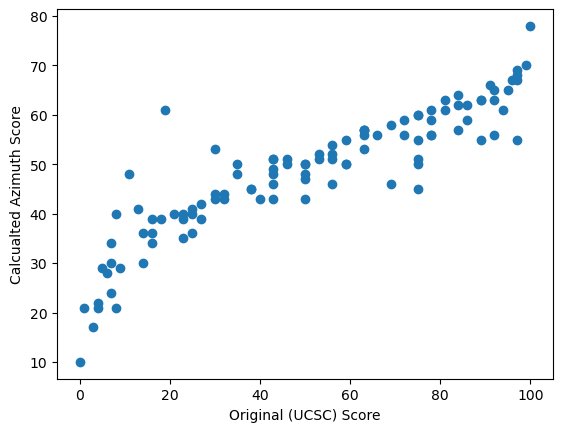

In [89]:
import scipy.stats
plt.scatter(score_ucsc, scores)
scipy.stats.spearmanr(score_ucsc, scores)
plt.xlabel('Original (UCSC) Score')
plt.ylabel('Calculated Azimuth Score')

# Error checking


In [4]:
from Bio.Align import PairwiseAligner
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [64]:
def sensor_outcome_corrected(p53_lib, i):
    #p53_lib = df containing pegRNA + target sequence + other info
    #i = index

    sensor_true = p53_lib.iloc[i]['wt_w_context']

    #let's quantify the homology overhang as well...
    PAM_strand = p53_lib.iloc[i]['PAM_strand']
    var_type = p53_lib.iloc[i]['Variant_Type']


    if PAM_strand=='+':
        sensor = Bio.Seq.Seq(p53_lib.iloc[i]['wt_w_context']).reverse_complement()

    elif PAM_strand=='-':
        sensor = p53_lib.iloc[i]['wt_w_context']

    pbs_length = p53_lib.iloc[i]['PBS_length']
    pbs = p53_lib.iloc[i]['RTT_PBS'][-pbs_length:]
    rtt = p53_lib.iloc[i]['RTT_PBS'][:-(pbs_length-1)] #FIXING [:-0] indexing issue...

    #pbs_rtt = p53_lib.iloc[i]['PBS_RTT_5to3']

    pbs_find = sensor.find(pbs)
    #print(pbs_find)

    #first compute the portion before the mutation for computing the right flank
    for kk, val in enumerate(reversed(rtt)):
        idx = pbs_find-kk
        if val!= sensor[idx]: #find first mismatch
            mut_start=kk
            break
        else:
            continue


    try: mut_start
    except: #case where's theres no identifiable change (because of homology overhang being too short/matching coincidentally...)
        return sensor_true, sensor_true, 0, "no homology overhang"

    #alignments = aligner.align(pbs, sensor)
    #print(alignments[0])

    #alignments = aligner.align(rtt, sensor)
    #print(alignments[0])

    #now we have the right flank...
    right_flank = rtt[-mut_start:-1] + sensor[pbs_find:]

    #alignments = aligner.align(right_flank, sensor)
    #print(alignments[0])
    
    if var_type in ['SNP', 'ONP']:

        matching_arr = np.zeros(len(rtt[:-mut_start]))

        for kk, val in enumerate(reversed(rtt[:-mut_start])):
            idx = pbs_find-mut_start-kk

            if val== sensor[idx]: #find regions of homology
                matching_arr[kk]+=1
                
            else:
                continue
        
        #based on values in match array, determine where mutation vs. homology overhang is...
        end_mut = np.where(matching_arr==0)[0][-1]

        mut_allele = rtt[-(mut_start+end_mut+1):-mut_start]
        homology_overhang = rtt[:-(mut_start+end_mut+1)]
        #this formulation will NOT catch situations where the homology overhang doesn't match???????
        #(though this shouldn't be an issue for SNPs/ONPs)

        left_flank = sensor[:(pbs_find-(len(rtt)-1))]

    elif var_type=='DEL':

        #find the size of the deletion by shifting and checking for matches...
        #will allow for detection of insufficient homology overhang...
        length_remaining = len(rtt[:-mut_start])
        homology_overhang = rtt[:-mut_start]
        mut_allele = ''

        start_idx = pbs_find-mut_start
        for i in range(len(sensor[:start_idx])): #check rest of the sensor...
        
            #sliding window to find size of deletion/perfect match...
            sensor_a = sensor[start_idx-i-length_remaining:start_idx-i]

            if sensor_a==homology_overhang: #once match is found, record and break...
                size_del = i
                break
        
            else:
                continue

        #error where the full homology overhang region not included in sensor...
        try: size_del
        except: 
            return sensor_true, sensor_true, len(homology_overhang), 'sensor too short' #no excepted editing, return WT sensor

        left_flank = sensor[:start_idx-size_del-length_remaining]

    elif var_type=='INS':

        length_remaining = len(rtt[:-mut_start])
        start_idx = pbs_find-mut_start+1

        for i in range(length_remaining):
            rtt_region = rtt[:-(mut_start+i)]
            sensor_a = sensor[start_idx-len(rtt_region):start_idx]

            #print('rt: ' + rtt_region)
            #print('s: ' + sensor_a)

            if sensor_a==rtt_region:
                mut_allele = rtt[-(mut_start+i):-mut_start]
                break
            else:
                continue

        #in case of no homology overhang...
        try: mut_allele
        except: 
            return sensor_true, sensor_true, 0, 'no homology overhang' #no excepted editing, return WT sensor

        homology_overhang = sensor_a
        left_flank = sensor[:start_idx-len(rtt_region)]

    edited_sensor = left_flank + homology_overhang + mut_allele + right_flank      

    if PAM_strand=='+':
        edited_sensor_true = str(Bio.Seq.Seq(edited_sensor).reverse_complement())

    elif PAM_strand=='-':
        edited_sensor_true=edited_sensor



    #alignments = aligner.align(rtt[-mut_start:], sensor)
    #print(alignments[0])

    #alignments = aligner.align(right_flank, sensor)
    #print(alignments[0])

    #alignments = aligner.align(homology_overhang, sensor)
    #print(alignments[0])

    #alignments = aligner.align(edited_sensor, sensor)
    #print(alignments[0])

    #alignments = aligner.align(edited_sensor_true, sensor_true)
    #print(alignments[0])


    return sensor_true, edited_sensor_true, len(homology_overhang), 'no error'

In [80]:

p53_lib = df[:50000]

#running it for every mutation in the p53 library
edit_sens = []
homo = []
idx_holder = []
classif = []
#del_idx = p53_del.index

#ins_idx = p53_lib[p53_lib['variant_type']=='SNP'].index

error = []
for i in range(len(p53_lib)):
    try:
        s, s_e, homo2, m = sensor_outcome_corrected(p53_lib, i)
        idx_holder.append(i)
        edit_sens.append(s_e)
        homo.append(homo2)
        classif.append(m)

        assert s_e == p53_lib['alt_w_context']
    
    except:
        error.append(i)

In [82]:
np.unique(classif, return_counts=True)

(array(['no error', 'no homology overhang', 'sensor too short'],
       dtype='<U20'),
 array([46234,  1972,    66]))

In [83]:
classif.index('sensor too short')

19976

In [84]:
df.iloc[[19976]]

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,...,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,Distance_to_nick,RHA_size,PAM_disrupted,Proto_disrupted
19976,494,TP53,17,7578285,7578288,"frameshift_variant,splice_region_variant",Frame_Shift_Del,DEL,CAGA,-,...,GTTCCTCACTGATTGCTCTT,TCGGATAAGATGCTGAGGAGGGGCCCTAAG,30,AGCAATCAGT,10,TCGGATAAGATGCTGAGGAGGGGCCCTAAGAGCAATCAGT,6,24,False,False
